In [1]:
# --------------------------------------------------------
# (사용시 쥬피터 노트북(.ipynb) 최상단 셀에 복붙하세요)
# --------------------------------------------------------

import sys, os
from pathlib import Path

# 현재 Jupyter Notebook이 실행된 디렉터리가 analysis/인 경우,
# Path().resolve()는 analysis/폴더 경로를 가리킵니다.
# 따라서 .parent.parent로 두 단계 올라가면 프로젝트 루트가 됩니다.
# 경로에 따라서 .parent의 개수를 조정하면 됩니다 최종 base root까지 
BASE_DIR = Path().resolve().parent.parent
# 혹은, 명시적으로 CWD(현재 작업 디렉터리)를 얻고 싶으면:
# BASE_DIR = Path(os.getcwd()).parent.parent

# 프로젝트 루트를 PYTHONPATH에 삽입
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# 이제 아래 임포트가 정상 동작합니다
from scripts.data_loader import load_data

# 테스트: pm10 데이터 불러오기 -> df_pm10 이 정상적으로 불러진다면 root_path의 설정이 완료 되었습니다.
# 만약 error 발생시 setup.py를 한번 실행시켜 주시기 바랍니다.
df_pm10 = load_data("pm10")

# Hypothesis 4 검증 예시: 성별별로 미세먼지의 질병 유발력이 다르게 나타난다.

=== 가설 #4: 성별별 미세먼지 효과 (Interaction) 분석 결과 ===


,disease,pm_type,coef_pm,p_pm,coef_inter,p_inter,r2,n_obs
0,asthma,pm10,562.422719,1.293805e-13,NaN,NaN,0.035060,3448
1,asthma,pm25,912.474578,1.074356e-09,NaN,NaN,0.037994,2204
2,rhinitis,pm10,1765.412095,5.752069e-04,NaN,NaN,0.011484,3448
3,rhinitis,pm25,6197.299890,3.697432e-06,NaN,NaN,0.025633,2204


=== 상호작용항 유의성 (True = 유의미) ===


,disease,pm_type,coef_inter,p_inter,interaction_significant
0,asthma,pm10,NaN,NaN,False
1,asthma,pm25,NaN,NaN,False
2,rhinitis,pm10,NaN,NaN,False
3,rhinitis,pm25,NaN,NaN,False


C:\Users\김남준\AppData\Local\Temp\ipykernel_13004\3997667029.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


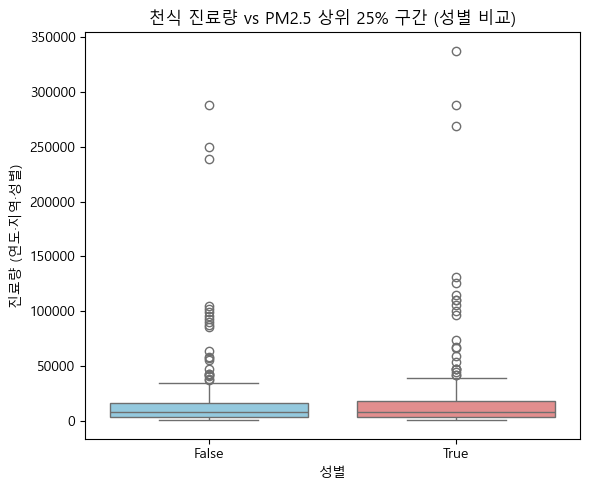

C:\Users\김남준\AppData\Local\Temp\ipykernel_13004\3997667029.py:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


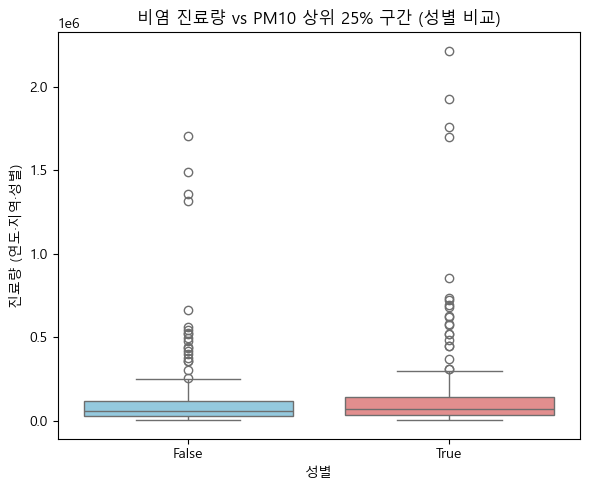

In [10]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.db_util import DustDB
import matplotlib

# 한글 폰트 설정 (필요하다면)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# ───────────────────────────────────────────────────────────────
# 1) DB 연결 및 각 테이블 로드
# ───────────────────────────────────────────────────────────────
db = DustDB()

# (a) 천식·비염 Fact 테이블 로드 (컬럼: id, ym, region, gender, age_group, visit_count)
df_asthma10 = (
    db.load_table("pm10_asthma_fact")
      .rename(columns={"region_name": "region"})
)
df_asthma25 = (
    db.load_table("pm25_asthma_fact")
      .rename(columns={"region_name": "region"})
)
df_rhinitis10 = (
    db.load_table("pm10_rhinitis_fact")
      .rename(columns={"region_name": "region"})
)
df_rhinitis25 = (
    db.load_table("pm25_rhinitis_fact")
      .rename(columns={"region_name": "region"})
)

# (b) PM10/PM2.5 Fact 테이블 로드 (컬럼: id, date_id, region, pm10 또는 pm25)
df_pm10 = (
    db.load_table("pm10_fact")
      .rename(columns={"region_name": "region"})
      [["date_id", "region", "pm10"]]
      .drop_duplicates()
)
df_pm25 = (
    db.load_table("pm25_fact")
      .rename(columns={"region_name": "region"})
      [["date_id", "region", "pm25"]]
      .drop_duplicates()
)

# ───────────────────────────────────────────────────────────────
# 2) “year” 컬럼 생성
# ───────────────────────────────────────────────────────────────

# (a) 천식·비염 Fact에는 “ym”이 YYYYMM 정수 또는 문자열 형태로 들어 있음
for df in [df_asthma10, df_asthma25, df_rhinitis10, df_rhinitis25]:
    if pd.api.types.is_integer_dtype(df["ym"]) or pd.api.types.is_float_dtype(df["ym"]):
        df["year"] = (df["ym"] // 100).astype(int)
    else:
        df["year"] = df["ym"].astype(str).str[:4].astype(int)

# (b) PM 테이블에는 “date_id”가 YYYYMM 정수 또는 문자열 형태로 들어 있음
for df in [df_pm10, df_pm25]:
    if pd.api.types.is_integer_dtype(df["date_id"]) or pd.api.types.is_float_dtype(df["date_id"]):
        df["year"] = (df["date_id"] // 100).astype(int)
    else:
        df["year"] = df["date_id"].astype(str).str[:4].astype(int)

# ───────────────────────────────────────────────────────────────
# 3) 연도·지역·성별별 진료량 집계 (visit_gender)
# ───────────────────────────────────────────────────────────────

def aggregate_visits_by_year_region_gender(df_disease):
    return (
        df_disease
        .groupby(["year", "region", "gender"], as_index=False)
        [["visit_count"]]
        .sum()
        .rename(columns={"visit_count": "visit_gender"})
    )

df_ast10_yr = aggregate_visits_by_year_region_gender(df_asthma10)
df_ast25_yr = aggregate_visits_by_year_region_gender(df_asthma25)
df_rhn10_yr = aggregate_visits_by_year_region_gender(df_rhinitis10)
df_rhn25_yr = aggregate_visits_by_year_region_gender(df_rhinitis25)

# ───────────────────────────────────────────────────────────────
# 4) “gender” 컬럼 값 한국어 → 영어로 매핑
#     예: '남자' → 'MAN', '여자' → 'WOMAN'
# ───────────────────────────────────────────────────────────────

mapping = {"남자": "MAN", "여자": "WOMAN"}
for df in [df_ast10_yr, df_ast25_yr, df_rhn10_yr, df_rhn25_yr]:
    df["gender"] = df["gender"].map(mapping)

# ───────────────────────────────────────────────────────────────
# 5) 연도·지역별 PM 평균 농도 계산
# ───────────────────────────────────────────────────────────────

def aggregate_pm_by_year_region(df_pm, pm_col):
    return (
        df_pm
        .groupby(["year", "region"], as_index=False)
        [[pm_col]]
        .mean()
        .rename(columns={pm_col: f"{pm_col}_yr_avg"})
    )

df_pm10_yr = aggregate_pm_by_year_region(df_pm10, "pm10")
df_pm25_yr = aggregate_pm_by_year_region(df_pm25, "pm25")

# ───────────────────────────────────────────────────────────────
# 6) 성별 One-Hot Encoding (drop_first=True) → "gender_WOMAN" 컬럼 생성
# ───────────────────────────────────────────────────────────────

df_ast10_yr = pd.get_dummies(df_ast10_yr, columns=["gender"], drop_first=True)
df_ast25_yr = pd.get_dummies(df_ast25_yr, columns=["gender"], drop_first=True)
df_rhn10_yr = pd.get_dummies(df_rhn10_yr, columns=["gender"], drop_first=True)
df_rhn25_yr = pd.get_dummies(df_rhn25_yr, columns=["gender"], drop_first=True)
# 이제 각 DataFrame에 "gender_WOMAN" 컬럼(0=남자, 1=여자)이 확실히 생성됨

# ───────────────────────────────────────────────────────────────
# 7) Interaction 회귀분석 함수 정의
# ───────────────────────────────────────────────────────────────

def analyze_interaction(df_visits, df_pm, pm_col, label_disease, label_pm):
    merged = pd.merge(
        df_visits,
        df_pm,
        on=["year", "region"],
        how="inner"
    ).dropna(subset=[f"{pm_col}_yr_avg", "visit_gender", "gender_WOMAN"])
    
    if merged.shape[0] < 5:
        return pd.DataFrame()
    
    formula = f"visit_gender ~ {pm_col}_yr_avg + gender_WOMAN + {pm_col}_yr_avg:gender_WOMAN"
    model = smf.ols(formula=formula, data=merged).fit()
    
    interaction_term = f"{pm_col}_yr_avg:gender_WOMAN"
    coef_main = model.params.get(f"{pm_col}_yr_avg", float("nan"))
    coef_inter = model.params.get(interaction_term, float("nan"))
    p_main = model.pvalues.get(f"{pm_col}_yr_avg", float("nan"))
    p_inter = model.pvalues.get(interaction_term, float("nan"))
    r2 = model.rsquared
    n_obs = merged.shape[0]
    
    return pd.DataFrame([{
        "disease":    label_disease,
        "pm_type":    label_pm,
        "coef_pm":    coef_main,
        "p_pm":       p_main,
        "coef_inter": coef_inter,
        "p_inter":    p_inter,
        "r2":         r2,
        "n_obs":      n_obs
    }])

# ───────────────────────────────────────────────────────────────
# 8) 천식·비염 × PM10/PM2.5 Interaction 분석 실행
# ───────────────────────────────────────────────────────────────

df_ast_pm10_int = analyze_interaction(df_ast10_yr, df_pm10_yr, "pm10", "asthma", "pm10")
df_ast_pm25_int = analyze_interaction(df_ast25_yr, df_pm25_yr, "pm25", "asthma", "pm25")
df_rhn_pm10_int = analyze_interaction(df_rhn10_yr, df_pm10_yr, "pm10", "rhinitis", "pm10")
df_rhn_pm25_int = analyze_interaction(df_rhn25_yr, df_pm25_yr, "pm25", "rhinitis", "pm25")

df_int_out = pd.concat([
    df_ast_pm10_int,
    df_ast_pm25_int,
    df_rhn_pm10_int,
    df_rhn_pm25_int
], ignore_index=True)

print("=== 가설 #4: 성별별 미세먼지 효과 (Interaction) 분석 결과 ===")
display(df_int_out)

# ───────────────────────────────────────────────────────────────
# 9) 상호작용 유의성 여부 (p_inter < 0.05 → 유의미)
# ───────────────────────────────────────────────────────────────

df_int_out["interaction_significant"] = df_int_out["p_inter"] < 0.05
print("=== 상호작용항 유의성 (True = 유의미) ===")
display(df_int_out[["disease", "pm_type", "coef_inter", "p_inter", "interaction_significant"]])

# ───────────────────────────────────────────────────────────────
# 10) 고농도(상위 25%) 구간 박스플롯
# ───────────────────────────────────────────────────────────────

# (a) 천식 vs PM2.5 고농도 구간
merged_asthma25 = pd.merge(
    df_ast25_yr,
    df_pm25_yr,
    on=["year", "region"],
    how="inner"
).dropna(subset=["pm25_yr_avg", "visit_gender", "gender_WOMAN"])

threshold_asthma25 = merged_asthma25["pm25_yr_avg"].quantile(0.75)
df_high_asthma25 = merged_asthma25[merged_asthma25["pm25_yr_avg"] >= threshold_asthma25]

if not df_high_asthma25.empty:
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        x="gender_WOMAN",
        y="visit_gender",
        data=df_high_asthma25.replace({"gender_WOMAN": {0: "MAN", 1: "WOMAN"}}),
        palette=["skyblue", "lightcoral"]
    )
    plt.title("천식 진료량 vs PM2.5 상위 25% 구간 (성별 비교)")
    plt.xlabel("성별")
    plt.ylabel("진료량 (연도·지역·성별)")
    plt.tight_layout()
    plt.show()
else:
    print("천식 vs PM2.5: 상위 25% 구간에 해당하는 데이터가 없습니다.")

# (b) 비염 vs PM10 고농도 구간
merged_rhn10 = pd.merge(
    df_rhn10_yr,
    df_pm10_yr,
    on=["year", "region"],
    how="inner"
).dropna(subset=["pm10_yr_avg", "visit_gender", "gender_WOMAN"])

threshold_rhn10 = merged_rhn10["pm10_yr_avg"].quantile(0.75)
df_high_rhn10 = merged_rhn10[merged_rhn10["pm10_yr_avg"] >= threshold_rhn10]

if not df_high_rhn10.empty:
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        x="gender_WOMAN",
        y="visit_gender",
        data=df_high_rhn10.replace({"gender_WOMAN": {0: "MAN", 1: "WOMAN"}}),
        palette=["skyblue", "lightcoral"]
    )
    plt.title("비염 진료량 vs PM10 상위 25% 구간 (성별 비교)")
    plt.xlabel("성별")
    plt.ylabel("진료량 (연도·지역·성별)")
    plt.tight_layout()
    plt.show()
else:
    print("비염 vs PM10: 상위 25% 구간에 해당하는 데이터가 없습니다.")